<a href="https://colab.research.google.com/github/JISU-byte/second-repository/blob/master/MainQuest_1112/House_Prices_Prediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주택 가격 예측하기!

메인퀘스트에 오신 것을 환영합니다!

이번 퀘스트의 목표는 여러 특성들을 종합적으로 고려하여 가장 주택 가격을 잘 예측하는 회귀모델을 만드는 것입니다.

- 예측할 값(y): SalePrice
- 평가지표: RMSE

퀘스트 진행 방식:

1. Code 란에서 테스트 노트북을 Copy&Edit 하여 작업!
2. 테스트 노트북을 submit 하여 리더보드에 정상적으로 등록되는지 확인하기
3. 자유롭게 모델을 발전시켜 좋은 성적 거두기!
4. 정상적으로 submit하고, 다음 구글폼에 이름/노트북주소/닉네임 등록!!!
- https://docs.google.com/forms/d/e/1FAIpQLSc0kXVZ9PRLbjsxBysCSSYLDiU4Hd9DLTvFrCFep4HLZLbL8w/viewform?usp=header

예시 형식:
~~~
Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.
~~~

### 데이터 확인 및 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [4]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [6]:
print("Train shape:", train_df.shape)
print(train_df.info())

Train shape: (1168, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

특성이 너무 많습니다! 어떻게 하면 좋을까요?

참고로 각각의 특성은 다음을 나타냅니다.

| 변수명               | 설명 (한국어)                         |
| ----------------- | -------------------------------- |
| **SalePrice**     | 주택의 판매 가격(달러). 예측해야 하는 타겟 변수     |
| **MSSubClass**    | 건물 등급(건물 종류 분류)                  |
| **MSZoning**      | 토지 용도 구분(일반적인 구역 분류)             |
| **LotFrontage**   | 도로에 접한 토지 길이 (피트 단위)             |
| **LotArea**       | 토지 면적 (평방 피트)                    |
| **Street**        | 도로 접근 방식                         |
| **Alley**         | 골목(후면 도로) 접근 방식                  |
| **LotShape**      | 토지의 전반적인 모양                      |
| **LandContour**   | 토지의 평탄도                          |
| **Utilities**     | 사용 가능한 공공시설(전기, 수도 등)            |
| **LotConfig**     | 토지 배치 형태                         |
| **LandSlope**     | 토지의 경사도                          |
| **Neighborhood**  | Ames 시 내의 물리적 위치(주변 지역)          |
| **Condition1**    | 주요 도로·철도에 대한 근접도                 |
| **Condition2**    | 두 번째 주요 도로·철도에 대한 근접도            |
| **BldgType**      | 주거 건물 유형 (단독, 다세대 등)             |
| **HouseStyle**    | 주택의 건축 양식                        |
| **OverallQual**   | 자재 및 마감 품질 종합 평가                 |
| **OverallCond**   | 주택의 전반적인 상태 평가                   |
| **YearBuilt**     | 최초 건축 연도                         |
| **YearRemodAdd**  | 리모델링/개조 연도                       |
| **RoofStyle**     | 지붕 스타일                           |
| **RoofMatl**      | 지붕 재료                            |
| **Exterior1st**   | 외장 마감재(주 재료)                     |
| **Exterior2nd**   | 외장 마감재(보조 재료, 2번째)               |
| **MasVnrType**    | 석조 베니어 타입                        |
| **MasVnrArea**    | 석조 베니어 면적 (평방 피트)                |
| **ExterQual**     | 외장재 품질 평가                        |
| **ExterCond**     | 외장재 상태 평가                        |
| **Foundation**    | 기초(Foundation) 유형                |
| **BsmtQual**      | 지하실 높이 평가                        |
| **BsmtCond**      | 지하실 상태 평가                        |
| **BsmtExposure**  | 지하실 외부 노출 여부(출입구/창문 등)           |
| **BsmtFinType1**  | 주요 지하실 마감 구역 유형                  |
| **BsmtFinSF1**    | 주요 지하실 마감 면적 (평방 피트)             |
| **BsmtFinType2**  | 보조 지하실 마감 구역 유형                  |
| **BsmtFinSF2**    | 보조 지하실 마감 면적 (평방 피트)             |
| **BsmtUnfSF**     | 미완성 지하실 면적 (평방 피트)               |
| **TotalBsmtSF**   | 지하실 전체 면적 (평방 피트)                |
| **Heating**       | 난방 시스템 종류                        |
| **HeatingQC**     | 난방 품질 및 상태                       |
| **CentralAir**    | 중앙 에어컨 설치 여부                     |
| **Electrical**    | 전기 시스템 종류                        |
| **1stFlrSF**      | 1층 면적 (평방 피트)                    |
| **2ndFlrSF**      | 2층 면적 (평방 피트)                    |
| **LowQualFinSF**  | 저품질 마감 공간 면적 (전체 층 합산)           |
| **GrLivArea**     | 지상(Above grade) 생활 공간 면적 (평방 피트) |
| **BsmtFullBath**  | 지하실 완비 욕실 수                      |
| **BsmtHalfBath**  | 지하실 반 욕실 수                       |
| **FullBath**      | 지상 완비 욕실 수                       |
| **HalfBath**      | 지상 반 욕실 수                        |
| **Bedroom**       | 지하실 제외 침실 수                      |
| **Kitchen**       | 주방 수                             |
| **KitchenQual**   | 주방 품질                            |
| **TotRmsAbvGrd**  | 지상 전체 방 개수 (욕실 제외)               |
| **Functional**    | 주택 기능성 평가                        |
| **Fireplaces**    | 벽난로 개수                           |
| **FireplaceQu**   | 벽난로 품질                           |
| **GarageType**    | 차고 위치(유형)                        |
| **GarageYrBlt**   | 차고 건축 연도                         |
| **GarageFinish**  | 차고 내부 마감 상태                      |
| **GarageCars**    | 차고 크기 (주차 가능 차량 수)               |
| **GarageArea**    | 차고 면적 (평방 피트)                    |
| **GarageQual**    | 차고 품질                            |
| **GarageCond**    | 차고 상태                            |
| **PavedDrive**    | 포장 진입로 여부                        |
| **WoodDeckSF**    | 목재 데크 면적 (평방 피트)                 |
| **OpenPorchSF**   | 오픈 현관 면적 (평방 피트)                 |
| **EnclosedPorch** | 밀폐된 현관 면적 (평방 피트)                |
| **3SsnPorch**     | 3계절용 현관 면적 (평방 피트)               |
| **ScreenPorch**   | 스크린 현관 면적 (평방 피트)                |
| **PoolArea**      | 수영장 면적 (평방 피트)                   |
| **PoolQC**        | 수영장 품질                           |
| **Fence**         | 울타리 품질                           |
| **MiscFeature**   | 기타 특수 기능                         |
| **MiscVal**       | 기타 기능의 금전적 가치                    |
| **MoSold**        | 판매 월                             |
| **YrSold**        | 판매 연도                            |
| **SaleType**      | 판매 유형                            |
| **SaleCondition** | 판매 조건                            |


In [8]:
train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [9]:
print(train_df.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      218
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [10]:
print(train_df["SalePrice"].describe())

count      1168.000000
mean     180194.401541
std       78869.201529
min       34900.000000
25%      129500.000000
50%      163995.000000
75%      213062.500000
max      755000.000000
Name: SalePrice, dtype: float64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


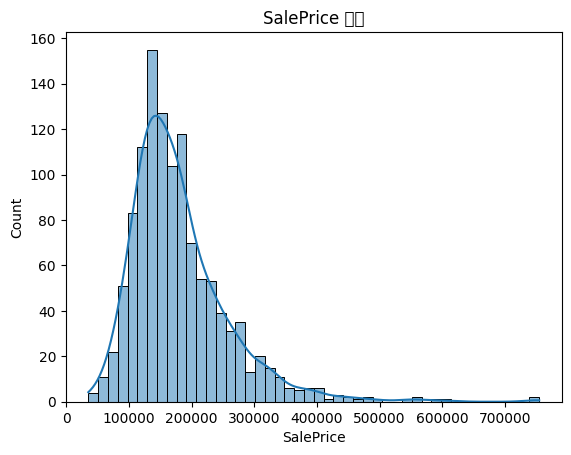

In [12]:
sns.histplot(train_df["SalePrice"], kde=True)
plt.title("SalePrice 분포")
plt.show()

In [13]:
# SalePrice와 주요 변수 상관관계
corr_cols = train_df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)[:10]
print("SalePrice와 상관관계 높은 변수들:\n", corr_cols)

SalePrice와 상관관계 높은 변수들:
 SalePrice       1.000000
OverallQual     0.785111
GrLivArea       0.710178
GarageCars      0.632622
GarageArea      0.618311
1stFlrSF        0.597729
TotalBsmtSF     0.595882
FullBath        0.577860
TotRmsAbvGrd    0.548795
YearRemodAdd    0.504817
Name: SalePrice, dtype: float64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

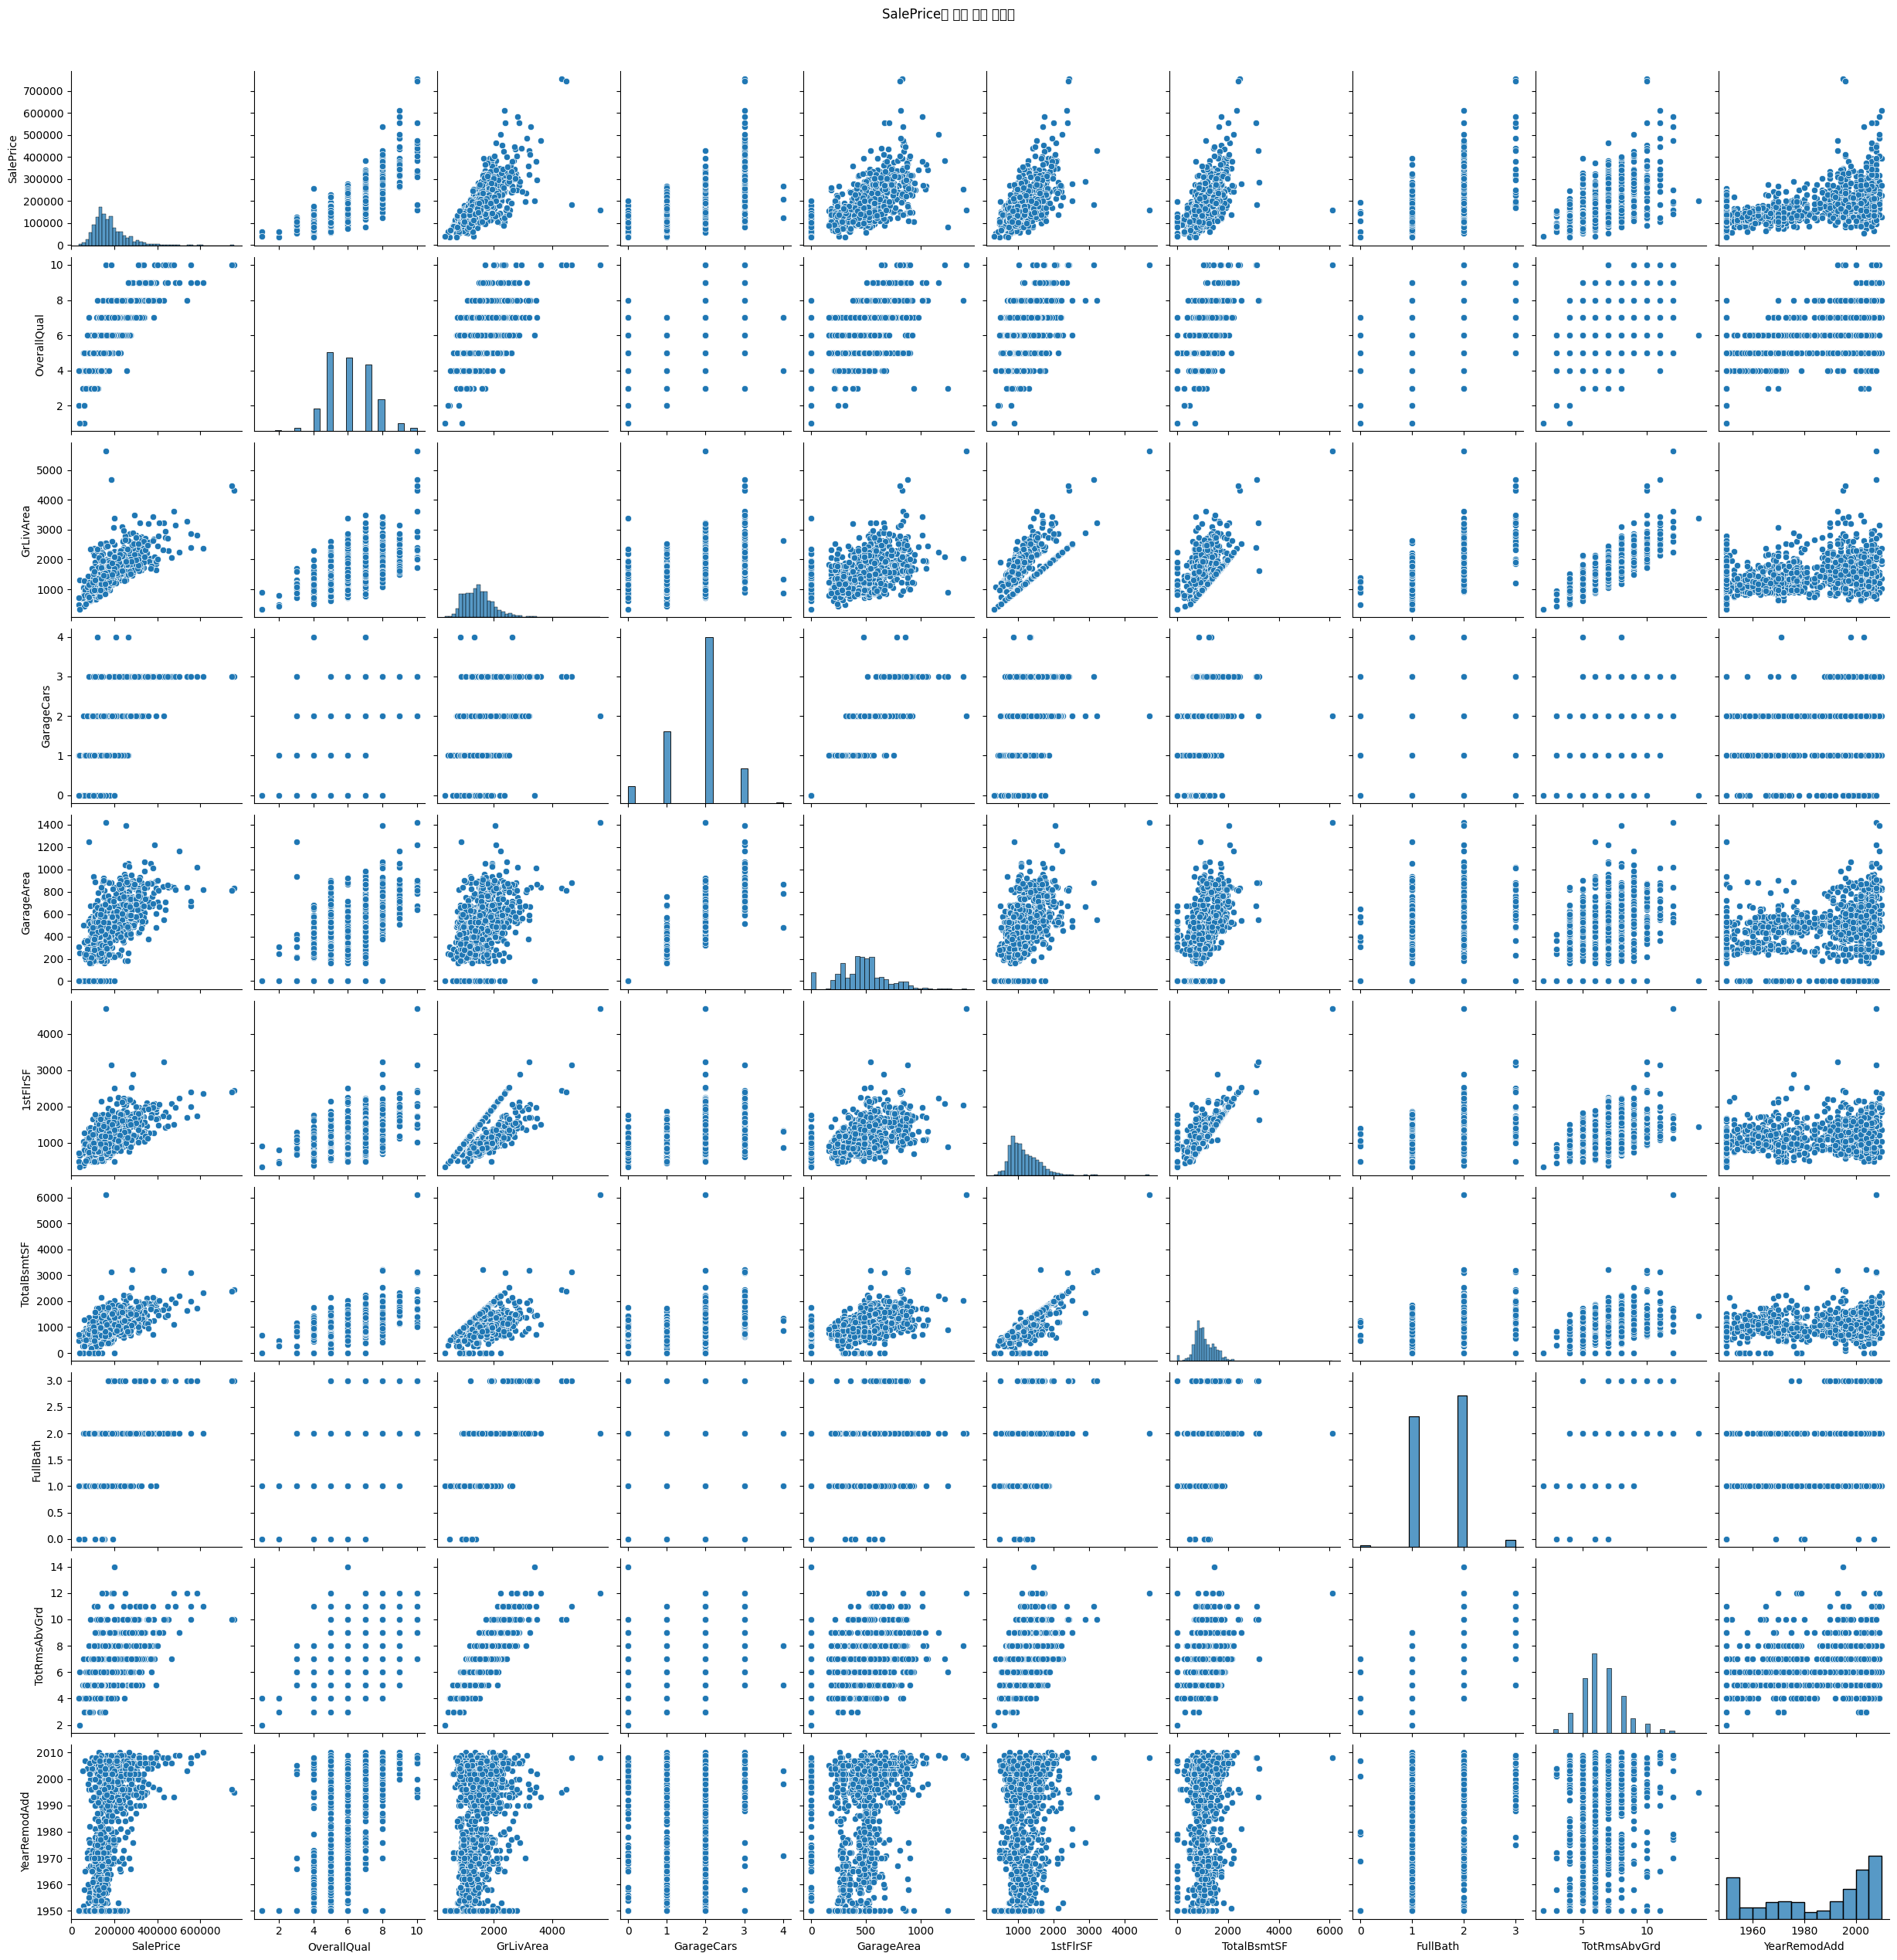

In [15]:
# 상관 상위 변수 시각화
top_corr = corr_cols.index
sns.pairplot(train_df[top_corr])
plt.suptitle("SalePrice와 상위 변수 시각화", y=1.02)
plt.show()

### 전처리

전처리에서 고민해야 할 것은 많습니다.

1. 결측치
2. 이상치

결측치는 처리하지 않으면 학습 자체가 불가할 수 있기 때문에, 최소한의 전처리로 결측치를 처리하겠습니다.

여러분들이라면 어떻게 결측치를 처리하면 좋을지 고민해보세요!

In [17]:
# 타깃 로그 변환 (왜도 완화)
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

In [19]:
# 숫자 / 범주형 구분
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.drop("SalePrice")
categorical_cols = train_df.select_dtypes(include=["object"]).columns

In [35]:
# 결측치 + 스케일링 + 인코딩 파이프라인
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore", sparse_output=False))

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

X = train_df.drop("SalePrice", axis=1)
y = train_df["SalePrice"]

### 모델 설정 및 학습

In [21]:
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=500, max_depth=20, min_samples_split=5, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=1000, learning_rate=0.05, max_depth=4, subsample=0.8, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=1500, learning_rate=0.05, max_depth=4, subsample=0.8,
        colsample_bytree=0.8, reg_lambda=1.0, random_state=42, tree_method="hist"
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=1500, learning_rate=0.05, max_depth=-1, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
}

In [33]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# 규제 강도 후보 설정
alphas = np.logspace(-3, 1, 100)

# Ridge/Lasso/ElasticNet에 스케일링 포함 파이프라인 적용 (redundant StandardScaler 제거)
# preprocessor에서 이미 스케일링을 처리하므로 여기서는 제거합니다.
ridge_pipeline = RidgeCV(alphas=alphas, cv=5)
lasso_pipeline = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=20000)
elastic_pipeline = ElasticNetCV(alphas=alphas, l1_ratio=[0.1, 0.5, 0.9], cv=5, random_state=42, max_iter=20000)

# 기존 모델 딕셔너리에 추가
models.update({
    "Ridge": ridge_pipeline,
    "Lasso": lasso_pipeline,
    "ElasticNet": elastic_pipeline
})

In [36]:
# 교차검증으로 모델 비교
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    rmse = np.sqrt(-cross_val_score(pipe, X, y, scoring="neg_mean_squared_error", cv=cv).mean())
    print(f"{name} RMSE: {rmse:.4f}")

RandomForest RMSE: 0.1521
GradientBoosting RMSE: 0.1325
XGBoost RMSE: 0.1376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3267
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 171
[LightGBM] [Info] Start training from score 12.007004


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3263
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 167
[LightGBM] [Info] Start training from score 12.021134


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3274
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 166
[LightGBM] [Info] Start training from score 12.020340


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3257
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 163
[LightGBM] [Info] Start training from score 12.024027


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 162
[LightGBM] [Info] Start training from score 12.030319


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM RMSE: 0.1371
Ridge RMSE: 0.1513
Lasso RMSE: 0.1497
ElasticNet RMSE: 0.1504


In [37]:
best_model = make_pipeline(preprocessor, GradientBoostingRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    random_state=42
))

### 테스트 데이터 예측 및 제출

In [38]:
best_model.fit(X, y)
# 예측 및 제출파일 생성
test_pred = np.expm1(best_model.predict(test_df))  # 로그변환 복원

submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": test_pred
})
submission.to_csv("submission.csv", index=False)
print("제출파일 생성 완료: submission.csv")

# 샘플 출력
print(submission.head())

제출파일 생성 완료: submission.csv
    Id      SalePrice
0   86  260773.250372
1  227  264920.223115
2  492  149332.078795
3   64  122226.369654
4  576  113494.747476
